In [19]:
import scipy.linalg as ln
import numpy as np
m, n = 2, 3
n_diag = min(m, n)
#Init normal standard random variable A with size (m, n)
A = np.random.rand(m, n)
U, S_diag, V = ln.svd(A)
#Create diagonal matrix S based on diagonal
S = np.zeros((n_diag, n_diag))
np.fill_diagonal(S, S_diag)
if m > n:
    S = np.concatenate((S, np.zeros((1, n))), axis = 0)
elif m < n:
    S = np.concatenate((S, np.zeros((m, 1))), axis = 1)
        
print('Matrix A: \n %s \n'%A)
print('orthogonal matrix U: \n %s \n'%U)
print('Check Frobenius U^TU-I: \n %s \n'%ln.norm(np.dot(U.T,U)-np.eye(m, m), 'fro'))
print('orthogonal matrix V: \n %s \n'%V)
print('Check Frobenius V^TV-I: \n %s \n'%ln.norm(np.dot(V.T,V)-np.eye(n, n), 'fro'))
print('Diagonal matrix S: \n %s \n'%S_diag)
print('Matrix S: \n %s \n'%S)
print('Check Frobenius U.S.V - A: \n %s \n'%ln.norm(np.dot(U, S.dot(V))-A,'fro'))

Matrix A: 
 [[0.99560424 0.38614233 0.2473078 ]
 [0.60333584 0.42017966 0.13010457]] 

orthogonal matrix U: 
 [[-0.82926612 -0.55885392]
 [-0.55885392  0.82926612]] 

Check Frobenius U^TU-I: 
 2.299169654905529e-16 

orthogonal matrix V: 
 [[-0.88219169 -0.42109328 -0.21075644]
 [-0.38101071  0.90132689 -0.20601137]
 [-0.27671045  0.10144105  0.95558414]] 

Check Frobenius V^TV-I: 
 3.175437271527312e-16 

Diagonal matrix S: 
 [1.31807801 0.14716481] 

Matrix S: 
 [[1.31807801 0.         0.        ]
 [0.         0.14716481 0.        ]] 

Check Frobenius U.S.V - A: 
 1.594436429147036e-16 



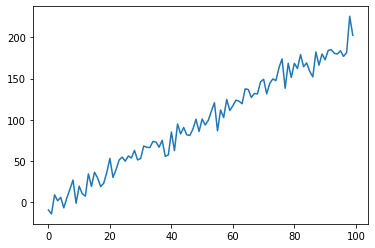

In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

n = 100
x = np.arange(n)

# add 1 column in the last of X to create X matrix
X = np.concatenate((x.reshape(n, 1), np.ones((n, 1))), axis = 1)
y = np.random.randn(n)*10 + 2*x
plt.plot(x, y)

In [21]:
# Calculate matrix A, b
A = np.dot(X.T, X)
b = np.dot(X.T, y)

# Matrix factorization SVD 
U, S_diag, V = np.linalg.svd(A)
S = np.zeros((S_diag.shape[0], S_diag.shape[0]))
np.fill_diagonal(S, S_diag)
S_inv = np.linalg.inv(S)

# Pseudo - inverse matrix
A_pse =  np.dot(V.T, np.dot(S_inv, U))

# Estimate coefficient
w_svd = np.dot(A_pse, b)
print('w calculated from SVD: %s' %str(w_svd))

w calculated from SVD: [ 2.04634967 -4.06450519]


In [22]:
from sklearn import linear_model
ln_reg = linear_model.LinearRegression(fit_intercept = False)
ln_reg.fit(X, y)
print('w calculated from sklearn: %s' %str(ln_reg.coef_))

w calculated from sklearn: [ 2.04634967 -4.06450519]


Image shape: (330, 500, 3)


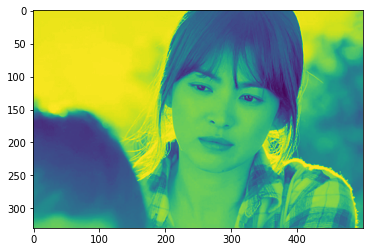

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as ln
from PIL import Image
import urllib.request
from io import BytesIO

%matplotlib inline

url = str('https://anh.eva.vn/upload/3-2017/images/2017-07-11/ghen-ti-voi-nhung-thu-chi-thuoc-ve-nu-than-han-quoc-song-hye-kyo-3-1499791578-width500height330.jpg')
with urllib.request.urlopen(url) as url:
    f = BytesIO(url.read())

ig = np.array(Image.open(f))
print('Image shape: %s'%str(ig.shape))
# Convert to grey
ig = ig.dot([0.299, 0.5870, 0.114])
plt.imshow(ig)

In [24]:
def SVD_pic(n_evl):
    """
    n_evl: number of highest eigenvalues taken
    """
    #Take m, n shape
    m = ig.shape[0]
    n = ig.shape[1]
    #Singular Value Decomposition
    U, S, V = ln.svd(ig) 
    #Get id position of n highest eigenvalues
    id_trunc = np.argsort(S)[::-1][:n_evl]
    #Extract matrix U_t, V_t, S_t
    U_t = U[np.ix_(np.arange(m), id_trunc)]
    V_t = V[np.ix_(id_trunc, np.arange(n))]
    S_diag = S[id_trunc]
    S_t = np.zeros((n_evl, n_evl))
    np.fill_diagonal(S_t, S_diag)
    #Return picture
    A = np.dot(U_t, S_t.dot(V_t))
    #Norm Frobenius
    fb = ln.norm(A-ig, 'fro')
    prt_retain = (1-fb**2/np.sum(S**2))*100
    plt.imshow(A)
    print('Percentage of information retained: %.2f%s \n'%(prt_retain, '%'))

Percentage of information retained: 99.39% 



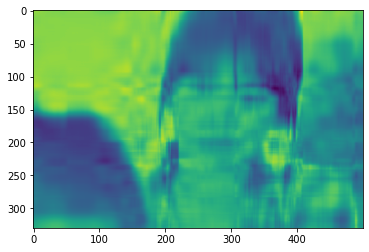

In [25]:
SVD_pic(10)

Percentage of information retained: 99.74% 



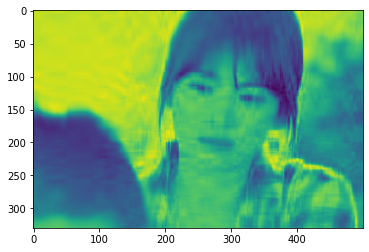

In [26]:
SVD_pic(20)

In [27]:
class Data(object):
    """
    This class used to manage data.
    Two arguments:
    dataset: pandas data frame include user_id, item_id and rating
    split_rate: number train ratings/ total ratings
    """
    def __init__(self, dataset, split_rate):
        self.dataset = dataset
        self.split_rate = split_rate
        self.train, self.test = self.split_train_test(self.dataset)
        self.n_users = np.max(self.train[:, 0] + 1) #plus one because index start from 0
        self.n_items = np.max(self.train[:, 1] + 1)
        self.Ytrain, self.Rtrain = self.utility_matrix(self.train)
        self.Ytest , self.Rtest  = self.utility_matrix(self.test)
        self.Ystad,  self.u_mean = self.standardize_Y(self.Ytrain)
        self.n_ratings = self.train.shape[0]
        
    def split_train_test(self, dataset):
        "split train and test"
        gb = dataset.groupby('user_id')
        ls = [gb.get_group(x) for x in gb.groups]
        items = [x for x in gb.groups]
        index_size = [{'i': i, 'index':gb.groups[i], 'size':len(gb.groups[i])} for i in items]
        index_train = pd.Int64Index([])
        index_test = pd.Int64Index([])
        for x in index_size:
            np.random.shuffle(x['index'].values)
            le = int(x['size']*self.split_rate)
            index_train = index_train.append(x['index'][:le])
            index_test = index_test.append(x['index'][le:])
        train = dataset.iloc[index_train].values
        test = dataset.iloc[index_test].values
        #minus id to 1 to index start from 0
        train[:, 0] -= 1
        train[:, 1] -= 1
        test[:, 0] -= 1
        test[:, 1] -= 1
        return train, test
    
    def utility_matrix(self, data_mtx):
        "create Y and R matrix"
        Y = np.zeros(shape = (self.n_items, self.n_users))
        Y = sparse.coo_matrix((data_mtx[:, 2], (data_mtx[:, 1], data_mtx[:, 0])), \
                              shape = (self.n_items, self.n_users), dtype = np.float).toarray()
        R = sparse.coo_matrix((np.ones((data_mtx.shape[0],)), (data_mtx[:, 1], data_mtx[:, 0])), \
                              shape = (self.n_items, self.n_users)).toarray()
        return Y, R
    
    def standardize_Y(self, Y):
        "standard data to mean ratings of each user = 0"
        sum_rating = Y.sum(axis = 0)
        u_rating = np.count_nonzero(Y, axis = 0)
        u_mean = sum_rating/u_rating
        for n in range(self.n_users):
            for m in range(self.n_items):
                if Y[m, n] != 0:
                    Y[m, n] -= u_mean[n]
        return Y, u_mean

In [28]:
class Model():
    """
    This class manage update U and I matrix, predict and evaluate error
    Two arguments:
    data: instance from Data class which supplies the data for model
    n_evl: number of eigenvalues
    """
    def __init__(self, data, n_evl = None):
        self.data = data
        self.n_evl = n_evl
        self.Yhat_std = self.fit(self.data, self.n_evl)
        self.Yhat = self.pred()
        
    def fit(self, data, n_evl):
        U, S, V = ln.svd(data.Ystad)
        #When n_evl is undefined, we set it equal to diagonal length
        if self.n_evl is None:
            n_evl = S.shape[0]
        #Get id position of n highest eigenvalues
        id_trunc = np.argsort(S)[::-1][:n_evl]
        #Extract matrix U_t, V_t, S_t
        U_t = U[np.ix_(np.arange(U.shape[0]), id_trunc)]
        V_t = V[np.ix_(id_trunc, np.arange(V.shape[1]))]
        S_diag = S[id_trunc]
        S_t = np.zeros((n_evl, n_evl))
        np.fill_diagonal(S_t, S_diag)
        #Return matrix forecast
        self.Yhat_std = np.dot(U_t, S_t.dot(V_t))
        return self.Yhat_std
    
    def pred(self):
        #invert to forecast values by plus user's mean ratings
        self.Yhat = self.Yhat_std.copy()
        for n in range(self.data.n_users):
            self.Yhat[:, n] += self.data.u_mean[n]
        #convert to interger values because of rating is integer
        self.Yhat = self.Yhat.astype(np.int32) 
        #replace values > 5 by 5 and values < 1 by 1
        self.Yhat[self.Yhat > 5] = 5
        self.Yhat[self.Yhat < 1] = 1
        return self.Yhat

    def pred_train_test(self, Yhat, R):
        #replace values have not yet rated by 0 
        Y_pred = Yhat.copy()
        Y_pred[R == 0] = 0
        return Y_pred
    
    def RMSE(self, Y, Yhat):
        error = Y - Yhat
        n_ratings = np.sum(Y != 0)
        rmse = math.sqrt(np.linalg.norm(error, 'fro')**2/n_ratings)
        return rmse

In [29]:
class MF():
    """
    This class used to manage model and data
    Two main arguments:
    data: control the data
    model: control the functions which execute model
    """
    def __init__(self, data, model):
        self.data = data
        self.model = model
        self.Y_pred_train = None
        self.Y_pred_test = None
        self.Yhat = None
        
    def fit(self):
        #fiting model
        self.model.fit(self.data, self.model.n_evl)
        #calculate Y_hat
        self.Yhat = self.model.pred()
        #calculate Y_pred_train by replace non ratings by 0
        self.Y_pred_train = self.model.pred_train_test(self.Yhat, self.data.Rtrain)
        self.Y_pred_test  = self.model.pred_train_test(self.Yhat, self.data.Rtest)
        print('RMSE: {}'.\
              format(self.model.RMSE(self.data.Ytest, self.Y_pred_test)))

    def recommend_for_user(self, user_id, k_neighbors):
        recm = np.concatenate((np.arange(1, self.Y_pred_test.shape[0]+1).reshape(-1, 1), \
                               self.Y_pred_test[:, user_id - 1].reshape(-1, 1)), axis = 1)
        recm.sort(axis = 0)
        print('Top %s item_id recommended to user_id %s: %s'%\
              (k_neighbors, user_id, str(recm[-k_neighbors:, 0])))

In [30]:
import numpy as np
import scipy.linalg as ln
import pandas as pd
import scipy.sparse as sparse
import math

columns = ['user_id', 'item_id', 'rating', 'timestamp']
movie_length = pd.read_csv('ratings.dat', header = 0, \
                           names = columns, sep = '::', engine = 'python')
movie_length = movie_length.sort_values(['user_id', 'item_id'])

data = Data(dataset = movie_length, split_rate = 2/3)

In [31]:
# Fitting model  
model = Model(data = data, n_evl = 2)
mf = MF(data = data, model = model)
mf.fit()

RMSE: 1.1429550281081393


explained variance ratio (first two components): [0.92461872 0.05306648]


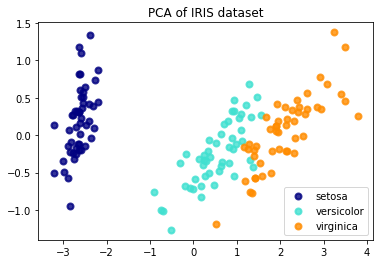

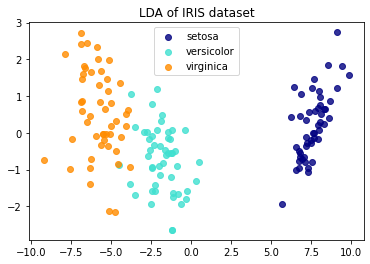

In [33]:
# Comparison of LDA and PCA 2D projection of Iris dataset
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print(
    "explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_)
)

plt.figure()
colors = ["navy", "turquoise", "darkorange"]
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(
        X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of IRIS dataset")

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(
        X_r2[y == i, 0], X_r2[y == i, 1], alpha=0.8, color=color, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA of IRIS dataset")

plt.show()